# Building a Network for the number of Components $K$

We want to build a network to learn the relationship between data and the number of components $K$ that make up the data. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/daniela/work/repositories/jumpingflows/code/") 

import seaborn as sns
sns.set_style("whitegrid")

import numpy as np

import torch

## Simplifying the Problem

I'm going to simplify the problem somewhat: a background parameter + two parameters per component (amplitude and position), and I'm also going to set the maximum number of $K$ to 5. 

Let's write a function to do that: 

In [2]:
from generate_data import simulate_burst

In [6]:
def simulate_burst_simple(time, ncomp, burstparams, return_model=False):
    """
    Simpler version of the the `simulate_burst` function 
    with fewer parameters. 
    
    We will set rise time, skewness and backgroung flux 
    to a constant value, which only leaves the peak time 
    and the amplitude as free parameters.

    **Important**: The amplitude in `burstparams` is defined 
    as a **log(amplitude)**, in contrast to the original 
    `generate_data` function, to make sampling easier.
    
    Parameters
    ---------
    time : numpy.ndarray
        The array of time stamps for which to compute 
        the model
        
    ncomp : int
        The number of `twoexp` components to include 
        in the sum

    burstparams : iterable
        An array containing the parameters for the 
        `twoexp` model. Flat array of the form
        `[t0_1, ..., t0_K, log(amp_1), ..., log(amp_K)]`
          
    ybkg : float
        The background flux
        
    return_model : bool, default False
        If True, return the model flux (without Poisson
        counts) along with the Poisson-drawn model 
        counts. If False, just contain the Poisson counts

    Returns
    -------
    ycounts : numpy.ndarray
        An array of the same size of $t$, returning the 
        model counts    
    """
    # set the fixed parameters for the simplified model
    ybkg = 10.0
    rise = np.ones(ncomp) * 0.02
    skew = np.ones(ncomp) * 3.0
    
    t0 = burstparams[:ncomp]
    amp = burstparams[ncomp:]
    
    burstparams_full = np.hstack([burstparams, rise, skew])
    
    if return_model:
        ym, ycounts = simulate_burst(time, ncomp, burstparams_full, ybkg, return_model=return_model)
        return ym, ycounts
    
    else: 
        ycounts = simulate_burst(time, ncomp, burstparams_full, ybkg, return_model=return_model)
        return ycounts

    

Okay, cool, next let's define some global parameters and some priors.

In [16]:
tstart = 0.0
tend = 1.0
nsteps = 1000

time = np.linspace(tstart, tend, nsteps)
dt = time[1] - time[0]

ybkg = 10.0

kmax = 5 # maximum number of components

# uniform prior on log-amplitude minimum 
# and maximum
log_amin = np.log(ybkg/2.0) 
log_amax = np.log(20*ybkg)

# uniform prior on peak time minimum 
# and maximum
tmin = tstart+0.1 #
tmax = tend - 0.1

Now we can use these to sample parameters from the prior:

In [26]:
nsims = 100000 # number of simulations to produce

# first, sample number of components in each simulation
k_all = np.random.randint(1, kmax+1, size=nsims)

# now loop over components and generate burst parameters 
# and data:
ymodel_all = np.zeros((nsims, time.shape[0]))
ycounts_all = np.zeros((nsims, time.shape[0]))
burstparams_all = []

for i, k in enumerate(k_all):
    log_amp = np.random.uniform(log_amin, log_amax, size=k)
    t0 = np.random.uniform(tmin, tmax, size=k)
    
    burstparams = np.hstack([t0, np.exp(log_amp)])
    burstparams_all.append(burstparams)
    
    ym, yc = simulate_burst_simple(time, k, burstparams, return_model=True)
    ymodel_all[i,:] = ym
    ycounts_all[i,:] = yc

In [29]:
np.savetxt("/Users/daniela/work/data/jumpingflows_simplified_bursts_data.dat", ycounts_all)
np.savetxt("/Users/daniela/work/data/jumpingflows_simplified_bursts_k.dat", k_all)

<IPython.core.display.Javascript object>


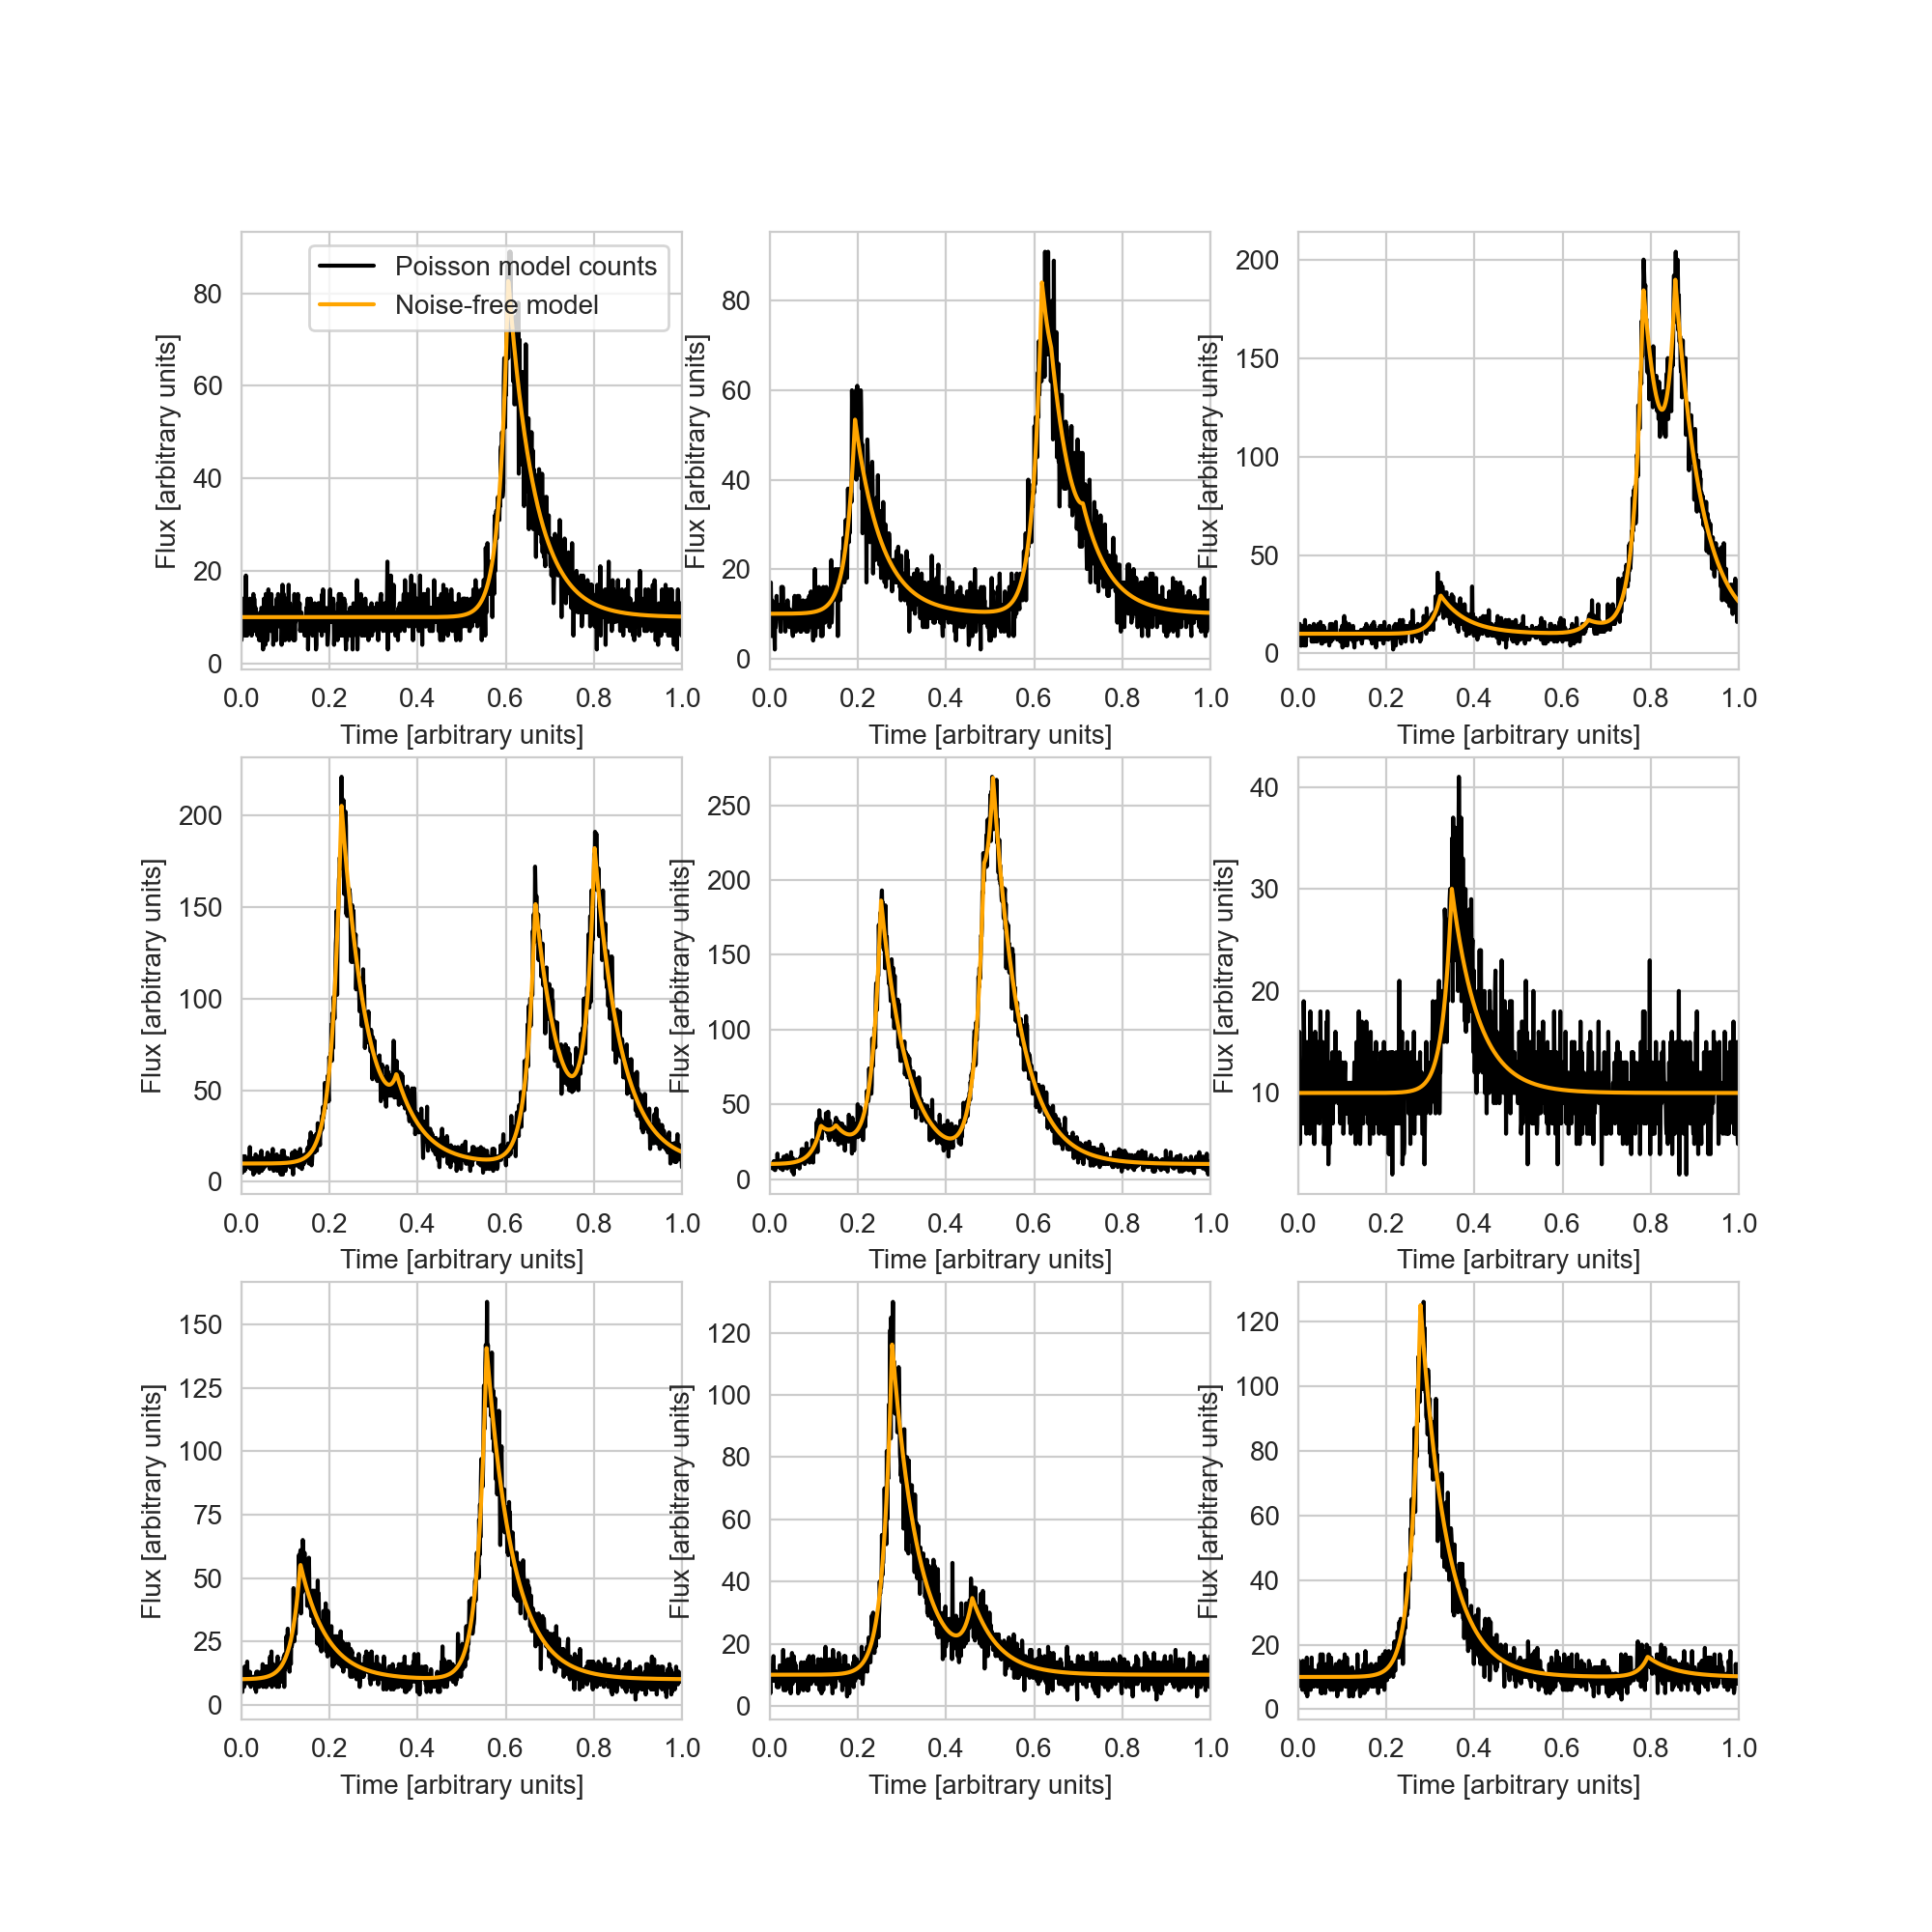

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

axes = np.hstack(axes)

for i, ax in enumerate(axes):
    ax.plot(time, ycounts_all[i,:], color="black", label="Poisson model counts")
    ax.plot(time, ymodel_all[i,:], color="orange", label="Noise-free model")
    ax.set_xlabel("Time [arbitrary units]")
    ax.set_ylabel("Flux [arbitrary units]")
    ax.set_xlim(time[0], time[-1]);
    if i == 0:
        ax.legend();

In [20]:
from torch.utils.data import Dataset

class BurstDataset(Dataset):
    def __init__(self, ncomp, data, transform=None, target_transform=None):
        self.ncomp = ncomp
        self.data = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.ncomp)

    def __getitem__(self, idx):
        theta = self.ncomp[idx]
        data = self.data[idx]
        
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            theta = self.target_transform(theta)
        return theta, data

In [21]:
Xtrain = BurstDataset(k_all, ycounts_all)

In [22]:
from torch import nn

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(1000, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [24]:
model = NeuralNetwork()

In [ ]:
X = torch.rand(1000, 1)
logits = model(X)

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(x, logits.detach().numpy().T)

In [ ]:
learning_rate = 1e-03
batch_size = 512
epochs = 100

loss_fn = nn.MSELoss()
model.double()

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

train_dataloader = DataLoader(Xtrain, batch_size=512, shuffle=True)
